<!-- ![](images/meepo.png){width=600 fig-align=center .preview-image} -->

I built a visual search engine for a leading fashion store in the Southern-most tip of Africa.
Thanks to the power and availability of foundational neural networks, open-source software, and cloud infrastructure -- with a sprinkle of good planning -- it took me 1 week and costs only $30 per month of hosting fees.

Honestly, it blows my mind that this is possible.
Decades of hard work by many bright minds have empowered us to create and distribute incredible AI-powered products from almost anywhere in the world.

I couldn't be more excited about what this means for our future.
What problems will we be able to solve?
This is why I decided to share how I built Meepo.
I hope to help others create even more powerful products that solve problems unique to their circumstances.

Here's the entire stack powering Meepo. Don't be overwhelmed. In this post, you'll learn about each and every one of these, and how you can use them to create your own search engine:

- [CLIP](https://github.com/openai/CLIP): the neural network underlying Meepo's visual search engine
- [Faiss](https://github.com/facebookresearch/faiss): a library that lets us efficiently search over CLIP outputs
- [Conda](https://docs.conda.io/en/latest/): a Python package management system
- [Jupyter Notebook](https://jupyter.org/): an interactive programming environment
- [nbdev](http://nbdev.fast.ai/): a platform for developing software using Jupyter Notebooks
- [Tailwind CSS](https://tailwindcss.com/): a simpler CSS framework
- [DaisyUI](https://daisyui.com/): a component library built on Tailwind CSS
- [SQLite](https://www.sqlite.org/): a light but powerful database engine
- [Django](https://www.djangoproject.com/): a battle-tested Python web framework
- [Gunicorn](): a Python HTTP server that lets us serve our Django application
- [Nginx](https://www.nginx.com/): a powerful and customizeable web server
- [Cron](https://cron.com/): a job scheduler built into Unix operating system
- [Linode](https://www.linode.com/): a cloud hosting provider.

## CLIP: Zero-shot text-image retrieval

::: {.callout-caution}
### This section is under construction

Check back in a few days.
:::

OpenAI's [CLIP](https://openai.com/blog/clip/) is the essential building block that powers Meepo.

The acronym stands for Contrastive Language-Image Pretraining. It is a neural network _pretrained_ to predict the most relevant text snippet given an image (and vice versa) on a dataset of 400 million image-text pairs collected from the internet.

It uses a _contrastive_ rather than _predictive_ objective: instead of directly predicting text snippet probabilities, it predicts a vector for each image and text snippet (called _embeddings_), then learns to maximize the cosine similarity of the correct pair and minimize that of the remaining pairs. The authors found that a contrastive objective reached the same zero-shot[^zero-shot] ImageNet accuracy as the predictive objective, while using 4x fewer images.

[^zero-shot]: Zero-shot means that a model was not trained on any examples from a given dataset. In this case, "zero-shot ImageNet accuracy" refers to the accuracy obtained by CLIP without being trained on any ImageNet examples.

![CLIP is pretrained with the contrastive objective of pairing images with text snippets. Source: [CLIP: Connecting Text and Images](https://openai.com/blog/clip/) by OpenAI.](images/clip-training.png){width=600 fig-align=center}

The CLIP [model source code and weights are open-source](https://github.com/openai/CLIP), which has allowed it to be leveraged by more recent innovations -- such as [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) -- the current state of the art open source generative image algorithm. However, OpenAI have not released the underlying dataset, WebImageText, nor have they shared much information about how it was collected. Fortunately, the open-source machine learning community have trained [OpenCLIP](https://github.com/mlfoundations/open_clip) from scratch on publicly available datasets, achieving similar zero-shot accuracy to CLIP itself.

<!-- The simple image retrieval pretraining task results in a neural network with zero-shot capabilities matching supervised approaches on a variety of downstream tasks and datasets. For example, CLIP matches the original ResNet-50 performance on ImageNet without training on any of its 1.28 million training examples. -->

While the retrieval pretraining task was originally chosen for its ability to learn useful representations for downstream tasks, CLIP still has excellent performance at the retrieval task itself.

The authors showed that CLIP was the state of the art method at zero-shot text-image retrieval (finding the relevant image given a text snippet), even outperforming finetuned methods on the Flickr30k dataset![^sota] However, finetuned approaches were superior on the MSCOCO dataset, and at image-text retrieval (finding the relevant text snippet given an image) on both datasets.

[^sota]: Fast forward two years and CLIP is no longer the state of the art at zero-shot text-image retrieval. Salesforce has been doing great work in this space. I recommend checking out their [LAVIS](https://github.com/salesforce/LAVIS) library as a starting point.

> **CLIP improves zero-shot retrieval and is competitive with the best fine-tuned result on Flickr30k text retrieval.**

This key finding is what enables CLIP to power a visual search engine like Meepo, given access to a dataset of images only, and without access to image-query pairs.

In [ ]:
!pip install -q torch datasets transformers

In [ ]:
#| output: false
from datasets import load_dataset

dataset = load_dataset("pcuenq/oxford-pets")

Using custom data configuration pcuenq--oxford-pets-43375e644eed3d52
Found cached dataset parquet (/Users/seem/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import numpy as np

In [ ]:
def thumbnail(image): return image.resize(np.array(image.size)//3)

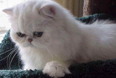

In [ ]:
cat_row = dataset['train'][15]
cat_image = cat_row['image']
thumbnail(cat_image)

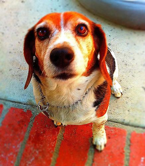

In [ ]:
dog_row = dataset['train'][10]
dog_image = dog_row['image']
thumbnail(dog_image)

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import torch

In [ ]:
def embed_image(image):
    inputs = processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_image_features(**inputs)

In [ ]:
embeddings = embed_image(image)
embeddings.shape

torch.Size([1, 512])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_bar(embeddings):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.bar(np.arange(embeddings.shape[1]), embeddings[0])

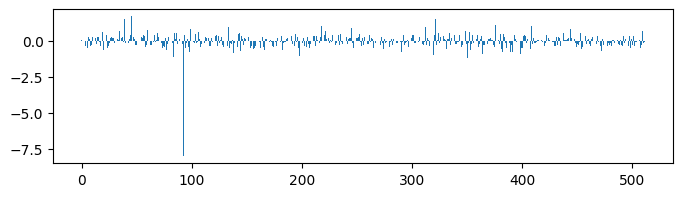

In [ ]:
plot_bar(embed_image(cat_image))

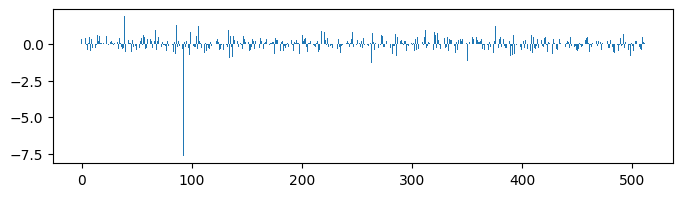

In [ ]:
plot_bar(embed_image(dog_image))

That's one way to visualize embeddings, but they are most useful in the context of other embedded objects.

Loading all images into memory at once would require about 17.2 GB of RAM. So we have to embed them one-by-one. An optimization could be to embed in chunks large enough to fit in memory, but this is simpler!

TODO: Maybe we can upload this as a huggingface dataset?

Let's embed all of the images. This took 19 minutes on my laptop:

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
%%time
embeddings = [embed_image(row['image']) for row in tqdm(dataset['train'])]

  0%|          | 0/7390 [00:00<?, ?it/s]

CPU times: user 33min 44s, sys: 1min 16s, total: 35min 1s
Wall time: 19min 17s


In [ ]:
emb = np.concatenate(embeddings)

In [ ]:
# np.save("oxford_pets_embeddings.npy", emb)

In [ ]:
emb2 = np.load("oxford_pets_embeddings.npy")

In [ ]:
assert np.allclose(emb, emb2)

## The idea

Leading up to Meepo, I'd seen the creator of [Lexica](https://lexica.art/) share the [details of their stack](https://twitter.com/sharifshameem/status/1567962701237997568?s=20) on Twitter. I'd also recently learned the detail behind how CLIP worked from the [most recent iteration of the incredible fastai course](https://www.fast.ai/posts/part2-2022-preview.html). Shortly after that, I saw [the launch](https://twitter.com/karinanguyen_/status/1587217615885406213) of [InterAlia](https://interalia.vcflab.org/). I had a brief look at the tech, and it looked simple enough to be able to very quickly prototype.

I wanted to build this as quickly as possible. And I wanted to do so in a series of incremental steps, each resulting in an end-to-end useable product.

## Notebook prototype

Later that day, I shared the first demo with friends:

{{< video videos/meepo-demo-1.mp4 >}}

In general, I always try to focus on the most uncertain part of the project at each step. At this stage I wasn't sure if the search would actually work for the types of queries a shopper would have, like "wooden bowl" or "small purple lamp". So the first step was to isolate and answer that specific question, as quickly as possible.

I manually scraped some images from the target website: literally opened the website and scraped the image URLs with some JavaScript in the browser console. I only scraped one page to start with, which was about 70 images. Then I CLIP encoded the images and did simple distance ranking on those vectors.

This took about 1 hour in total. And it worked quite well!

## Web prototype

The next step was to do the same thing in a web app. The simplest approach I could think of was a server-side rendered app that served static pages with a search interface implemented as a standard HTML form.

As for design, I knew that I was going to use an existing component library so that I could have a decent UI without much customization. I really like the way DaisyUI's components look, and it's free, so I went with that. I love how it turned out!

I started out by drawing a simple design with pen and paper. Even though this is a pretty basic design, I found it very helpful to draw it out. It gave me a clear goal to work towards. This is also when I decided on the name "Meepo", which my wife suggested. It's the name of a [DotA character](https://dota2.fandom.com/wiki/Meepo) that she liked, and it felt like the right vibe.

![](images/meepo-sketch.png){width=600 fig-align=center}

I used Django as the backend framework since I have a few years of experience with it. Again, since the goal was to ship fast, I tried to go with what I knew: simple, boring, but powerful! I used SQLite too to keep things simple, since it’s almost entirely a read-only application; only the scraper writes to the database.

This step took 4 hours, after which I shared another demo with friends.

{{< video videos/meepo-demo-2.mp4 >}}

## Deployment

Now that I had a minimal working Django app, I wanted to deploy it so that I could share a link for people to play around with, instead of just videos. I found it very helpful to get feedback throughout the process, and there's nothing better than getting feedback on an actual interactive version of the product. I also wanted to get practice shipping changes to a live app. I definitely think it's the right idea to deploy early in the development process, then ship often.

I used the battle-tested stack of nginx and gunicorn in front of Django (image created by [Serdar Ilarslan](https://medium.com/@serdarilarslan), [source](https://medium.com/@serdarilarslan/what-is-gunicorn-5e674fff131b)):

![](images/meepo-stack.webp)

This step took 7 hours. I think it could've been a lot faster, but I got sidetracked trying to use a platform-as-a-service (PaaS) option instead of working directly on a Linux virtual private server (VPS) – which I'm much more experienced with. I'm not sure if I'll revisit PaaS in the future, because the VPS has been working really well for a few months now. I personally love the transparency and being able to directly interact with it if anything goes wrong, rather than struggling to find the right logs in some web interface. I knew that [Pieter Levels](https://twitter.com/levelsio) does similarly, and serves significantly more traffic than I expected to. My good friend [Ashton Hudson](https://twitter.com/ashtonshudson) took the same approach with [Serval](https://www.servaltracker.com/), which also serves tons of traffic with a really massive time series database (more info in [this thread](https://twitter.com/ashtonshudson/status/1609621491481460737?s=20)).

I bought a DNS using Namecheap. I tried to find the cheapest domain for "meepo", and was lucky to score [meepo.shop](https://meepo.shop) at $2!

I did some basic Linux setup following [this Linode guide](https://www.linode.com/docs/products/compute/compute-instances/guides/set-up-and-secure/). Things like updating packages, configuring the timezone, configuring a custom hostname, and most importantly creating a limited user and tightening SSH options.

I found the docs really difficult to follow, but it turned out to be quite simple to get Linode to manage the DNS instead of Namecheap. All I had to do was go to the domain management page, then the Domain tab, and add Linode's nameservers under the Nameservers section. The domains were ns1.linode.com through ns5.linode.com. I think it might've taken some time to reflect, and once it did, I could create a domain in the Linode console, link it to my Node, and have it automatically fill what I needed!

As part of this step, I also setup nginx and gunicorn on the Linux VPS. I followed [this Real Python guide](https://realpython.com/django-nginx-gunicorn).

I also highly recommend setting up Longview, which has a free option! It's really cool to be able to check some basic stats from the console and even from my phone.

I also setup [Sentry](https://sentry.io/) which sends me an email whenever there's an error in either the web server or the scraper, with a neat stacktrace and local variables. It's very easy with Django, just a few lines in your `settings.py` file and you're good to go.

Once it was setup, I used [ddosify](https://github.com/ddosify/ddosify) to load test it – great tool! Given that I'd barely done any optimization, I wanted to make sure that it could at least handle a reasonable amount of traffic. So I hit the search endpoint with a bunch of random queries. It just about handled 60 requests over 10 seconds, which I was relatively sure I wouldn't reach for an extended period of time 😅 and worst case I could upgrade the VPS if needed.

![](images/meepo-ddosify.png)

Now I could tell people to goto [meepo.shop](https://meepo.shop) and see what I was working on. Yay! 🎉

## Scraper

The next step was to come up with a scraping strategy and pipeline design. This was probably the trickiest, but fortunately this sort of work has been a large part of my role as an ML Engineer 💪🏽.

The big question here is how do we maintain a list of available products that is accurate for at least 24 hours, with minimal load to the upstream service?

**A very important detour:** if you're scraping, you are most likely not the intended audience of a website, so try very hard not to negatively impact the service or the user experience of their intended audience! Here are some ways you can do so:

- Check how big the viewership of the website is. I would personally be hesitant to scrape a small website and would probably prefer to email the owner directly.
- Identify yourself (website URL), with contact information, via the user agent header – don't try to fake being a human! A simple pattern you can use is `your.website.com/x.y (your@email.com)` where `x.y` is a version number of the scraper.
- Be considerate about their resource usage, especially given that you aren't their intended audience.
- Do the bulk of your requests during off-peak times depending on the local timezone of their audience.
- Sleep between requests as much as you possibly can. Add small random amounts as well to reduce the likelihood of overlapping with other scheduled scrapers/bots, thus reducing peak load.
- Use compression when scraping plain text or JSON to minimise their outgoing traffic! It doesn't work nearly as well for images so it's probably best to not compress them to avoid extra CPU usage on their servers.

The rough idea was to:

1. First scrape the entire "catalogue". Walk through each department's "New in" section
2. Then for each page in the section, create a list of the currently available products.
3. Download the images for those products that we haven't seen before.
4. Calculate their CLIP embeddings
5. And finally rebuild the index.

It's faster for me to recreate the index instead of updating the existing one due to the small size of my dataset. For larger datasets this would be a more complex process.

Unfortunately, I couldn't scrape new pages only. I needed to check the entire catalogue to determine which products were unavailable so I can remove them from the index.

I first tried jumping in head first and coding this up, but got totally stuck. Even with that plan I wasn't quite sure how to break it down into smaller components that I could easily build.

A perfect opportunity to whip out a whiteboard, or in my case [Excalidraw](https://excalidraw.com). Here's what I came up with:

![](images/meepo-pipeline.png){.column-screen}

I often find it helpful to think about data pipelines in terms of statements that I want to be true about the data.

For example, after step 1, we should have a .json.gz file for each scraped page, in a folder structure indicating the run timestamp, department, and page number. It's also useful to specify a more precise schema at this point too. What would the file structure look like? What tables will you create in the database, and what are their constraints and foreign key relationships?

It's also often a good idea to store raw external data before we do any processing so that when we change the logic we don't need to rescrape anything. For example, if I wanted to add prices to products I could do so without rescraping anything. This is also one good reason for splitting a pipeline into smaller components. Another is that it can be easier to comprehend, although splitting it too fine can be counterproductive.

I used Chrome dev tools to figure out the API paths and what the requests should look like. Although I built the scraper to work with all departments, I started out by scraping the smallest one: Home and Living. I figured that would be a neat way to test the end-to-end process.

I then configured cron to run this daily just after midnight. By the way, a neat tip to get cron to log its output (including errors) to the system log is to add the following to the end of your job definition:

```sh
2>&1 | logger -t meepo_pipeline
```

The `2>&1` redirects the standard error stream to the standard out stream so that error messages are logged too. The combined result is then piped to the `logger` application which writes to the system log, with a tag specified by the `-t` flag.

Building out the scraper and getting the cron job working smoothly took about 20 hours! After that, all that was left was to let it scrape all departments, watch and fix any bugs that popped up (unhandled cases and so on), and prepare for launch!

## Launch

My launch plan was simple. Post to Twitter, LinkedIn, Reddit (/r/southafrica), and HackerNews:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Introducing Meepo – a smarter search engine for <a href="https://twitter.com/superbalist?ref_src=twsrc%5Etfw">@Superbalist</a> (leading South African fashion and homeware store 🇿🇦)<br><br>I have no affiliation with Superbalist. I just thought this was something that needed to exist! Let me explain...<a href="https://t.co/5HNOfM6k1T">https://t.co/5HNOfM6k1T</a></p>&mdash; Wasim Lorgat (@wasimlorgat) <a href="https://twitter.com/wasimlorgat/status/1596038255236915200?ref_src=twsrc%5Etfw">November 25, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

There are a couple of tiny details that really add to the polish of a launch: having a nice social preview card (and other metadata) and a favicon.

For the preview card, I used [Unsplash](https://unsplash.com/) to find a beautiful stock photo, and then [Canva](https://www.canva.com/) to edit it. Be sure to get the dimensions right for the website(s) you're targeting. For me it was primarily Twitter and Reddit. I cropped the image, played around with colour settings, added text, and added some pretty fonts and effects. I was inspired by Lexica's card which I think is really beautiful. I added a headline and short description over the image.

For favicons, my goto is a simple 1 or 2 letters with a nice font in the same colour scheme as the website. I used [favicon.io](https://favicon.io/) to create mine. You can use emojis too, which I might consider in the future.

Here's the stock image I used, credit to [Harper Sunday](https://unsplash.com/@harpersunday) ([source](https://unsplash.com/photos/RmQWqLKsVv8)):

![](images/meepo-stock.avif){width=400 fig-align=center}

At some point I'd like to start working with a designer for these sorts of things. Let me know if you're interested!

This step took about 4 hours total.

## Image search

Thanks to the power of CLIP, it was really easy to add image search after launching the site.

Here's how it works. I try to parse the search query, and if it's a URL of an image (and the image isn't larger than some file limit), I download the image (in-memory, I don't wanna store arbitrary files), calculate its CLIP embedding, and use that to find similar images.

One possible improvement is to use the average of the image embedding and the text embedding as the query, which I suspect is closer to what users expect from the feature. For example, a user might take an average of the image and the existing text query, which is closer to what I think people would expect.

This took 2 hours to implement end-to-end.

{{< video videos/meepo-demo-3.mp4 >}}

## Cost

The biggest cost here was really the ~40 hours it took to build. Other than that, Meepo cost me $30/month via Linode. The bottleneck is RAM. I need a 4GB server, which adds a fair bit to the cost, though I definitely could've reduced that by playing around with something like [autofaiss](https://github.com/criteo/autofaiss).

## That's all folks

All-in-all, I had tons of fun working on Meepo!

If you found this helpful or entertaining, please do follow me on Twitter [@wasimlorgat](https://twitter.com/wasimlorgat). And if you have any feedback, comments or questions, please feel free to pop me [an email](mailto:mwlorgat@gmail.com).

I'm now building my own native macOS Jupyter frontend. If that sounds interesting, the best place to follow along is via Twitter.

Take care 👋🏽.